# 0.0 IMPORTS

In [117]:
import math
import pickle
import datetime
import inflection
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb

from IPython.core.display  import HTML
from IPython.display       import Image
from boruta                import BorutaPy
from scipy                 import stats as ss
from matplotlib            import pyplot as plt

from sklearn.linear_model  import LinearRegression, Lasso
from sklearn.ensemble      import RandomForestRegressor
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics       import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error


### 0.1 Helper Functions

In [85]:

def cramer_v ( x,y ):
    cm= pd.crosstab(x,y).values
    n = cm.sum()
    r,k = cm.shape
    
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1) )
    
    kcorr= k - (k-1)**2 / (n-1)
    rcorr= r - (r-1)**2 / (n-1)
    
        
    return np.sqrt( ( chi2corr/n ) / ( min( kcorr-1, rcorr-1 ) ) )
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [15, 8]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()
    

def mean_absolute_percentage_error2(y, yhat):
    return np.mean(np.abs( ( y - yhat )/ y ))

def mean_percentage_error(y, yhat):
    return np.mean( ( y - yhat )/ y )


def ml_error(model_name, y, yhat):
    mae = mean_absolute_error(y, yhat)
#     mape = mean_absolute_percentage_error(y, yhat)
    mape = mean_absolute_percentage_error2(y, yhat)
    rmse = np.sqrt( mean_squared_error(y, yhat) )
    
    return pd.DataFrame({ 'Model Name': model_name,
                          'MAE':mae,
                          'MAPE':mape,
                          'RMSE': rmse }, index=[0])
 
def cross_validation( x_training, kfold, model_name, model, verbose=False ):
    mae_list = []
    mape_list = []
    rmse_list = []
    
    for k in reversed( range( 1, kfold+1 ) ):
       
        if verbose:
            print( '\nKFold Number: {}'.format( k ) )

        # start and end date for validation

        validation_start_date = x_training['date'].max() - datetime.timedelta(days=k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta(days=(k-1)*6*7)

        # filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

        # training and validation dataset    
        # training
        xtraining = training.drop( ['date', 'sales'], axis=1 )
        ytraining = training['sales']
        
        # validation
        xvalidation = validation.drop( ['date', 'sales'], axis=1 )
        yvalidation = validation['sales']
        
        # model
        m = model.fit( xtraining, ytraining )
        
        # prediction
        yhat = m.predict( xvalidation )
        
        # performance
        m_result = ml_error( model_name, np.expm1( yvalidation ), np.expm1( yhat ) )
        
        # store performance of each kfold iteration
        mae_list.append( m_result['MAE'] )
        mape_list.append( m_result['MAPE'] )
        rmse_list.append( m_result['RMSE'] )
    
    return pd.DataFrame( {'Model Name': model_name,'MAE CV': np.round( np.mean( mae_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mae_list ), 2 ).astype( str ),
                          'MAPE CV': np.round( np.mean( mape_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mape_list ), 2 ).astype( str ),
                          'RMSE CV': np.round( np.mean( rmse_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( rmse_list ), 2 ).astype( str )}, index=[0])

In [5]:
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


### 0.2 Loading Data

In [6]:
df_sales_raw = pd.read_csv('data/train.csv', low_memory=False)
df_store_raw = pd.read_csv('data/store.csv', low_memory=False)

#merge

df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on = 'Store')

# 1.0. PASSO 1 - DESCRIÇÃO DOS DADOS

In [7]:
df1 = df_raw.copy()

## 1.1 Rename Columns

In [8]:
cols_old =[ 'Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
            'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
            'CompetitionDistance', 'CompetitionOpenSinceMonth',
            'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
            'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x : inflection.underscore( x )
cols_new = list( map( snakecase,cols_old ) )

#rename
df1.columns = cols_new

## 1.2 Data Dimensions

In [9]:
print(f'Number of Rows: {df1.shape[0]}')
print(f'Number of Columns: {df1.shape[1]}')

Number of Rows: 1017209
Number of Columns: 18


## 1.3 Data Types

In [10]:
df1['date']=pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 Check NA

In [11]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 Fillout NA

In [12]:
df1['competition_distance'].max()

75860.0

In [13]:
# competition_distance    
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

# competition_open_since_month 
df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month']) else x['competition_open_since_month'],axis=1)

# competition_open_since_year  
df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year']) else x['competition_open_since_year'],axis=1)
                  
# promo2_since_week
df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week']) else x['promo2_since_week'],axis=1)

# promo2_since_year            
df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year']) else x['promo2_since_year'],axis=1)

# promo_interval 
month_map = {  1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec' }

df1['promo_interval'].fillna( 0, inplace=True )

df1['month_map'] = df1['date'].dt.month.map( month_map)

df1['is_promo'] = df1[['promo_interval','month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis =1)


## 1.6 Change Types

In [14]:
# df1.dtypes

In [15]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype('int64')
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype("int64")
df1['promo2_since_week'] = df1['promo2_since_week'].astype("int64")
df1['promo2_since_year'] = df1['promo2_since_year'].astype("int64")


## 1.7 Descriptive Statistical

In [16]:
num_attributes = df1.select_dtypes(include=['int64','float64'])
cat_attributes = df1.select_dtypes(exclude=['int64','float64','datetime64[ns]'])

## 1.7.1 Numerical attributes

In [17]:
# Central Tendency -  media e mediana - são metricas de tendência central (central tendency)
ct1 = pd.DataFrame( num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame( num_attributes.apply(np.median)).T

# Dispersion - desvio padrão, variância, range. min, max, skew, curtosis  - são metricas de dispersão
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( min )).T
d3 = pd.DataFrame( num_attributes.apply( max )).T
d4 = pd.DataFrame( num_attributes.apply(lambda x: x.max() -  x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply(lambda x: x.skew() ) ).T
d6= pd.DataFrame( num_attributes.apply(lambda x: x.kurtosis() ) ).T
                  
#concatenate
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes','min','max','range','mean','median','std','skew','Kurtosis',]

In [18]:
m

,attributes,min,max,range,mean,median,std,skew,Kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


## 1.7.2 Categorical Attributes

In [19]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

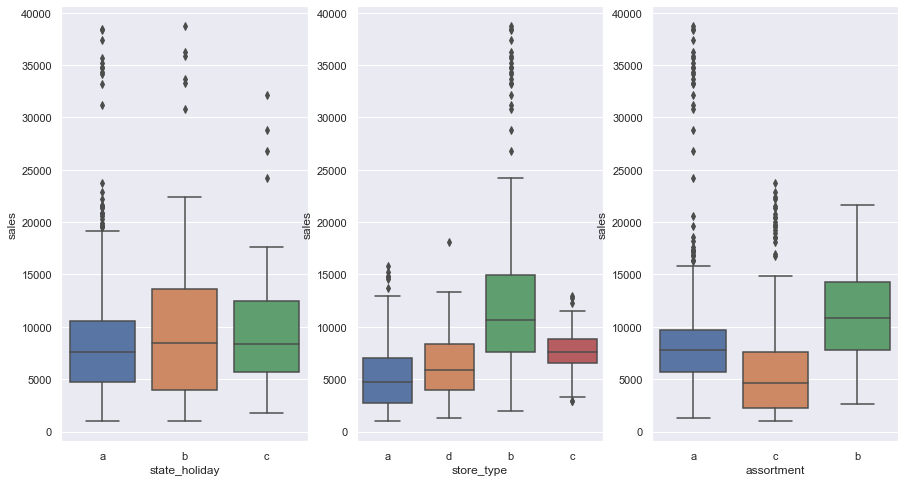

In [20]:

aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.subplot(1, 3, 1)
sns.boxplot(x='state_holiday' , y='sales' ,data=aux1 )

plt.subplot(1, 3, 2)
sns.boxplot(x='store_type' , y='sales' ,data=aux1 )

plt.subplot(1, 3, 3)
sns.boxplot(x='assortment' , y='sales' ,data=aux1 )

# 2.0. PASSO 2 - FEATURE ENGINEERING

In [21]:
df2= df1.copy()

## 2.1 Mapa mental de Hipóteses

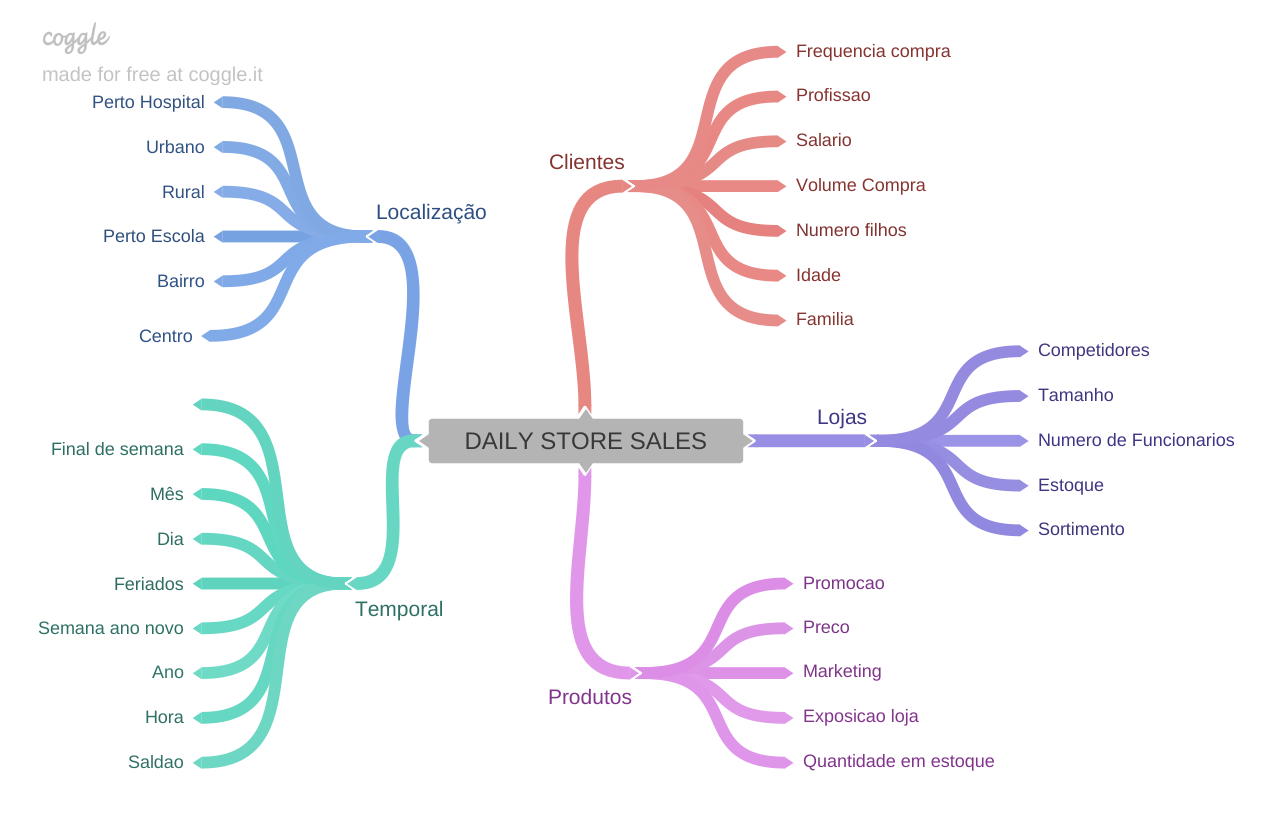

In [22]:
Image('img\MindMapHypotesis.png')

## 2.2 Criaçao das Hipóteses

### 2.1.1. Hipoteses Lojas

**1** Lojas com maior número de funcionários deveriam vender mais.

**2** Lojas com maior capacidade de estique deveriam vender mais.

**3** Lojas com maior porte deveriam vender mais.

**4** Lojas com maior sortimento deveriam vender mais.

**5** Lojas com competidores mais próximos deveriam vender menos.

**6** Lojas com maior competidores a mais tempo deveriam vender mais.

### 2.1.2. Hipoteses Produtos

**1** Lojas que investem mais em marketing deveriam vender mais.

**2** Lojas com exposição de produto deveriam vender mais.

**3** Lojas com produtos com menor preço deveriam vender mais.

**4** Lojas com promoções mais agressivas (descontos maiores) deveriam vender mais.

**5** Lojas com promoções ativas por mais tempo deveriam vender mais.

**6** Lojas com mais dias de promoção deveriam vender mais.

**7** Lojas com mais promoções consecutivas deveriam vender mais.

### 2.1.3. Hipoteses Tempo

**1** Lojas abertas durante o feriado de Natal deveriam vender mais.

**2** Lojas deveriam vender mais ao longo dos anos.

**3** Lojas deveriam vender mais no segundo semestre do ano.

**4** Lojas deveriam vender mais depois do dia 10 de cada mês.

**5** Lojas com promoções ativas por mais tempo deveriam vender mais.

**6** Lojas deveriam vender menos aos finais de semana.

**7** Lojas deveriam vender menos durante os feriados escolares.

## 2.3 Lista Final de Hipósteses

**1** Lojas com maior sortimento deveriam vender mais.

**2** Lojas com competidores mais próximos deveriam vender menos.

**3** Lojas com maior competidores a mais tempo deveriam vender mais.

**4** Lojas com promoções ativas por mais tempo deveriam vender mais.

**5** Lojas com mais dias de promoção deveriam vender mais.

**6** Lojas com mais promoções consecutivas deveriam vender mais.

**7** Lojas abertas durante o feriado de Natal deveriam vender mais.

**8** Lojas deveriam vender mais ao longo dos anos.

**9** Lojas deveriam vender mais no segundo semestre do ano.

**10** Lojas deveriam vender mais depois do dia 10 de cada mês.

**11** Lojas com promoções ativas por mais tempo deveriam vender mais.

**12** Lojas deveriam vender menos aos finais de semana.

**13** Lojas deveriam vender menos durante os feriados escolares.

## 2.4 Feature Engineering

In [23]:
# year
df2['year'] = df2['date'].dt.year
# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.weekofyear


# year week
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

# competition since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'] , month= x['competition_open_since_month'], day= 1 ), axis=1 )

df2['competition_time_month'] = ((df2['date'] - df2['competition_since']) / 30).apply(lambda x: x.days).astype(int)

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ))

df2['promo_time_week'] =  ((df2['date'] - df2['promo_since']) / 7).apply(lambda x: x.days).astype(int)

# assorment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x =='b' else 'extended')

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x== 'b' else 'christmas' if x =='c' else 'regular_day')

C:\Users\vande\AppData\Local\Temp\ipykernel_13260\542461104.py:10: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df2['week_of_year'] = df2['date'].dt.weekofyear


# 3.0. PASSO 3 - FILTRAGEM DE VARIÁVEIS

In [24]:
df3=df2.copy()

## 3.1. Filtragem das Linhas

In [26]:
df3 = df3[(df3['open']!= 0) & (df3['sales'] > 0)]

## 3.2. Seleção da colunas

In [27]:
cols_drop = ['customers','open','promo_interval','month_map']
df3 = df3.drop(cols_drop, axis=1)

# 4.0. PASSO 4 - ANÁLISE EXPLORATÓRIA DE DADOS

In [30]:
df4 = df3.copy()

## 4.1 Análise Univariada 

### 4.1.1 Response variable

C:\Users\vande\anaconda3\envs\ds-em-producao\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='sales', ylabel='Density'>

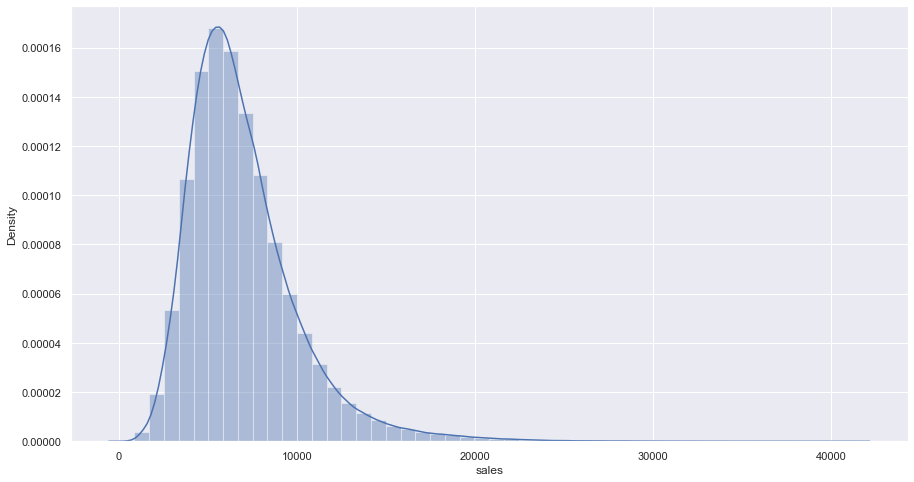

In [31]:
sns.distplot(df4['sales'])

### 4.1.2 Numerical  variable

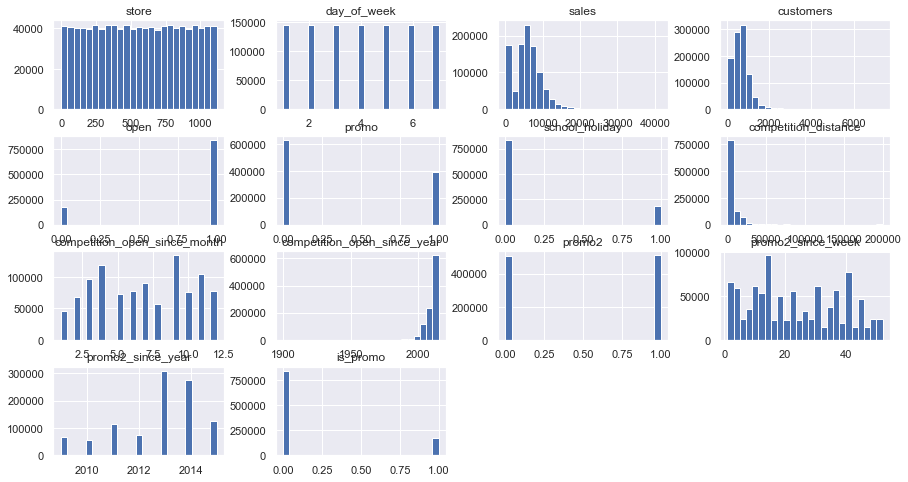

In [32]:
num_attributes.hist(bins=25);

### 4.1.3 Categorical variable

In [33]:
df4['assortment'].drop_duplicates()

0         basic
3      extended
258       extra
Name: assortment, dtype: object

C:\Users\vande\anaconda3\envs\ds-em-producao\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\vande\anaconda3\envs\ds-em-producao\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\vande\anaconda3\envs\ds-em-producao\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinte

<AxesSubplot:xlabel='sales', ylabel='Density'>

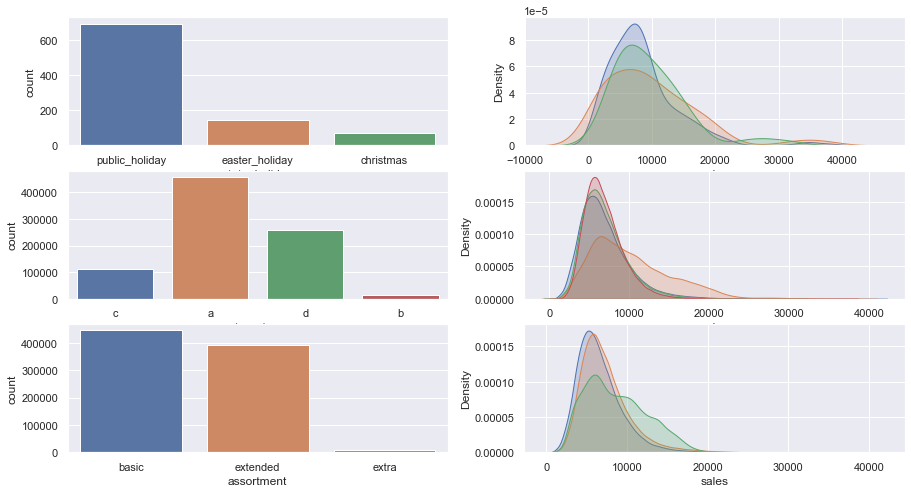

In [34]:
#state_holiday
plt.subplot(3,2,1) # linha, coluna, pos. graf
a= df4[df4['state_holiday'] != 'regular_day']
sns.countplot(a['state_holiday'])

plt.subplot(3,2,2) # linha, coluna, pos. graf
sns.kdeplot(df4[ df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True)
sns.kdeplot(df4[ df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True)
sns.kdeplot(df4[ df4['state_holiday'] == 'christmas']['sales'], label='christmas', shade=True)


#store_type
plt.subplot(3,2,3) # linha, coluna, pos. graf
sns.countplot(df4['store_type'])

plt.subplot(3,2,4) # linha, coluna, pos. graf
sns.kdeplot(df4[ df4['store_type'] == 'a']['sales'], label='a', shade=True)
sns.kdeplot(df4[ df4['store_type'] == 'b']['sales'], label='b', shade=True)
sns.kdeplot(df4[ df4['store_type'] == 'c']['sales'], label='c', shade=True)
sns.kdeplot(df4[ df4['store_type'] == 'd']['sales'], label='d', shade=True)


#assorment

plt.subplot(3,2,5) # linha, coluna, pos. graf
sns.countplot(df4['assortment'])

plt.subplot(3,2,6) # linha, coluna, pos. graf
sns.kdeplot(df4[ df4['assortment'] == 'basic']['sales'], label='basic', shade=True)
sns.kdeplot(df4[ df4['assortment'] == 'extended']['sales'], label='extended', shade=True)
sns.kdeplot(df4[ df4['assortment'] == 'extra']['sales'], label='extra', shade=True)


## 4.2 Análise Bivariada

### **H1.** Lojas com maior sortimento deveriam vender mais.
**VERDADEIRA** Lojas com SORTIMENTO MAIOR vendem MAIS, porém se olharmos o valor total de vendas as lojas com sortimento basis e extended são a grande maioria pelo número de lojas com cada tipo de sortimento.


<AxesSubplot:xlabel='year_week'>

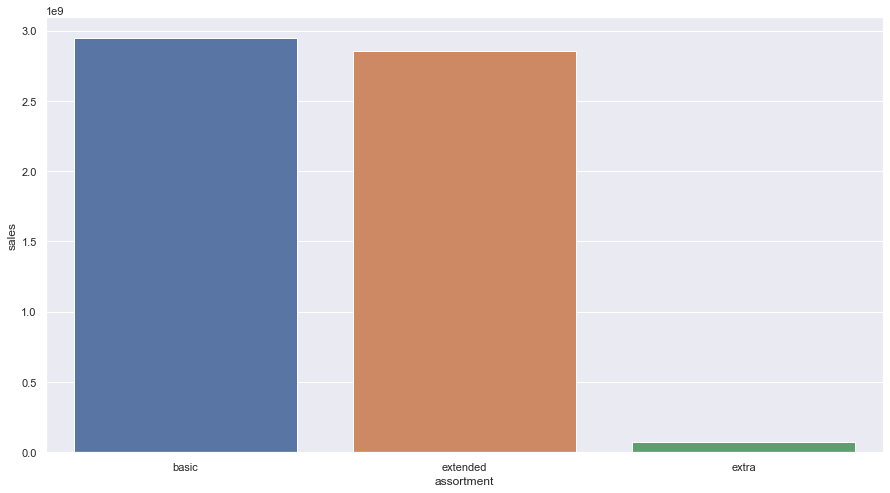

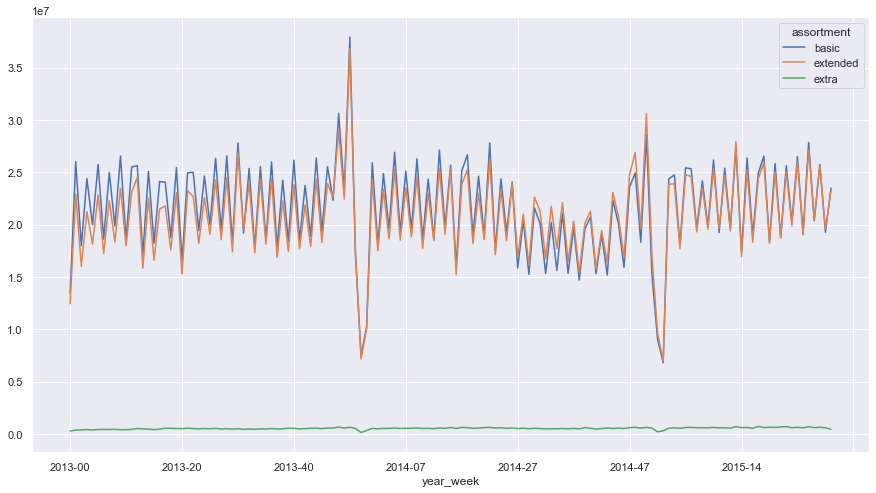

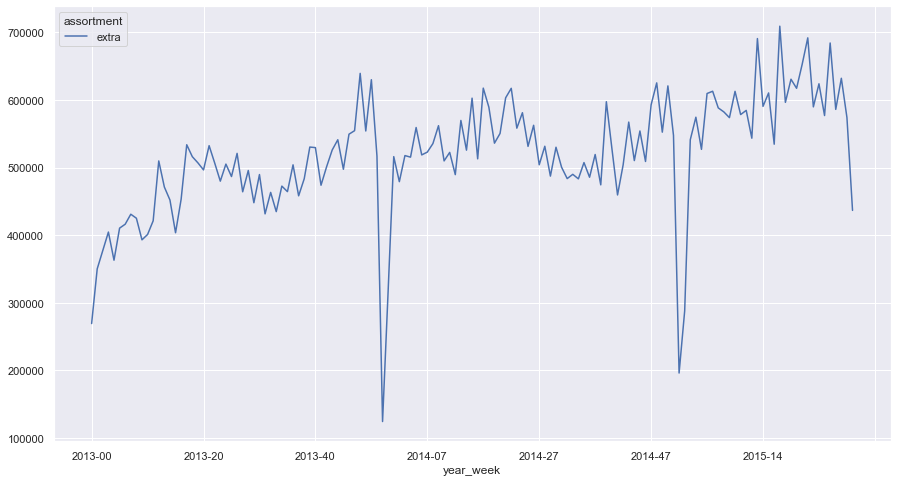

In [35]:
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot( x= 'assortment' , y= 'sales' , data= aux1 );

aux2 = df4[['year_week','assortment', 'sales']].groupby(['year_week', 'assortment'] ).sum().reset_index()
aux2.pivot(index='year_week' , columns='assortment' , values='sales' ).plot()
# sns.barplot( x= 'year_week' , y= 'sales' , data= aux3 );
aux3 = aux2[aux2['assortment'] =='extra']
aux3.pivot(index='year_week' , columns='assortment' , values='sales' ).plot()

,assortment,sales
0,basic,6621.523057
1,extended,7300.843547
2,extra,8642.503594


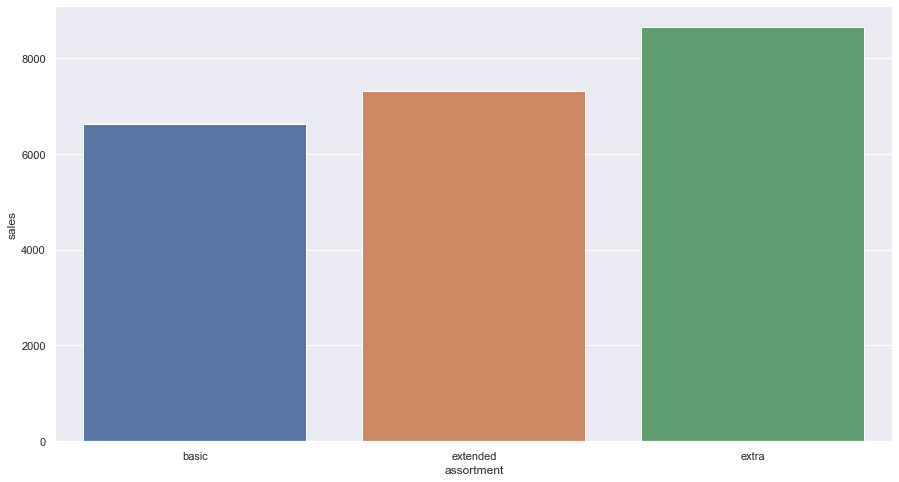

In [36]:
aux1 = df4[['assortment', 'sales']].groupby('assortment').mean().reset_index()
sns.barplot(x='assortment', y='sales',data=aux1)
aux1

### **H2** Lojas com competidores mais próximos deveriam vender menos.
**FALSA**  Lojas com competidores mais próximos vendem mais

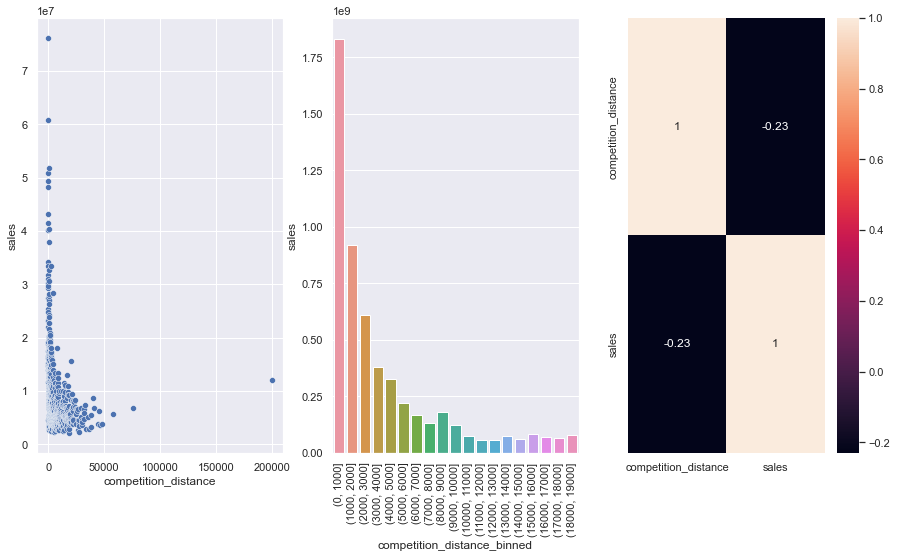

In [37]:
aux1 = df4[['competition_distance','sales']].groupby('competition_distance').sum().reset_index()

plt.subplot(1, 3, 1)
sns.scatterplot(x= 'competition_distance' , y='sales', data= aux1 )

plt.subplot(1, 3, 2)
bins = list( np.arange(0, 20000, 1000))
aux1['competition_distance_binned']  = pd.cut( aux1['competition_distance'], bins = bins)
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot(x= 'competition_distance_binned' , y='sales' , data=aux2 )
plt.xticks(rotation=90);

plt.subplot(1, 3, 3)
x = sns.heatmap(aux1.corr(method = 'pearson' ),annot=True)


### **H3** Lojas com maior competidores a mais tempo deveriam vender mais.
**FALSA** Lojas com COMPETIDORES a MAIS TEMPO vendem MENOS

<AxesSubplot:>

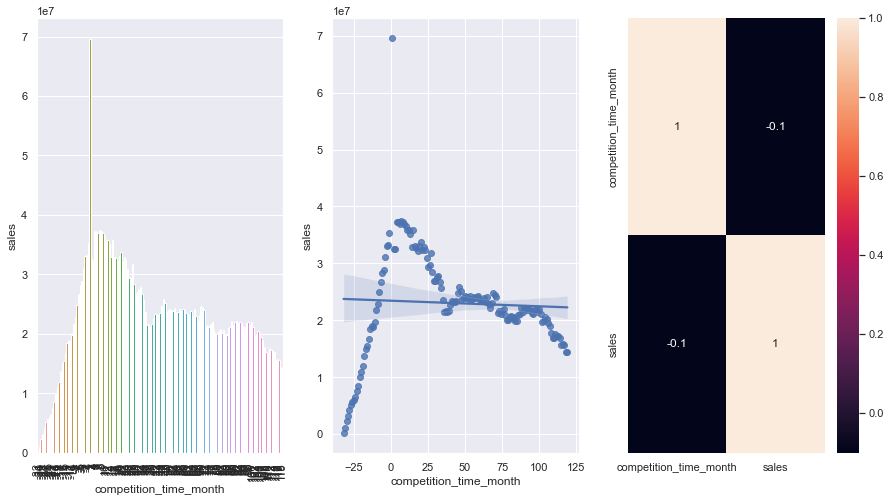

In [38]:
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()

plt.subplot(1, 3, 1)
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0 )]
sns.barplot(x='competition_time_month', y='sales', data=aux2)
plt.xticks(rotation=90);

plt.subplot(1, 3, 2)
sns.regplot(x='competition_time_month', y='sales', data=aux2)

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)


### H4 Lojas com promoções ativas por mais tempo deveriam vender mais.
**FALSA** Pois lojas com promoções ativas por mais tempo vendem menos, depois de uma certo tempo.

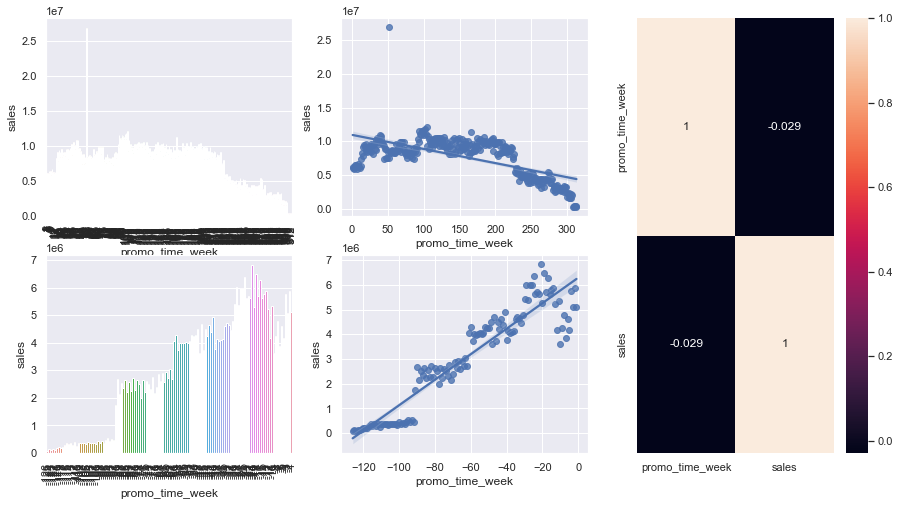

In [39]:
aux1= df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()
sns.barplot(x='promo_time_week' , y= 'sales' , data= aux1)

grid = GridSpec(2, 3)

plt.subplot(grid[0,0])
aux2 = aux1[aux1['promo_time_week'] > 0] # periodo normal de promoção
sns.barplot(x='promo_time_week', y='sales', data= aux2)
plt.xticks(rotation=90);

plt.subplot(grid[1,0])
aux3 = aux1[aux1['promo_time_week'] < 0] # periodo extendido de promoção
sns.barplot(x='promo_time_week', y='sales', data= aux3)

plt.xticks(rotation=90);

plt.subplot(grid[0,1])
sns.regplot(x='promo_time_week', y='sales', data= aux2)

plt.subplot(grid[1,1])
sns.regplot(x='promo_time_week', y='sales', data= aux3)

plt.subplot(grid[:,2])
sns.heatmap(aux1.corr( method='pearson'), annot= True);



### <s>H5 Lojas com mais dias de promoção deveriam vender mais.</s>

### H6 Lojas com mais promoções consecutivas deveriam vender mais.
**FALSA** Lojas com promoções consecutivas vendem menos.


In [40]:
df4[['promo','promo2','sales']].groupby(['promo', 'promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


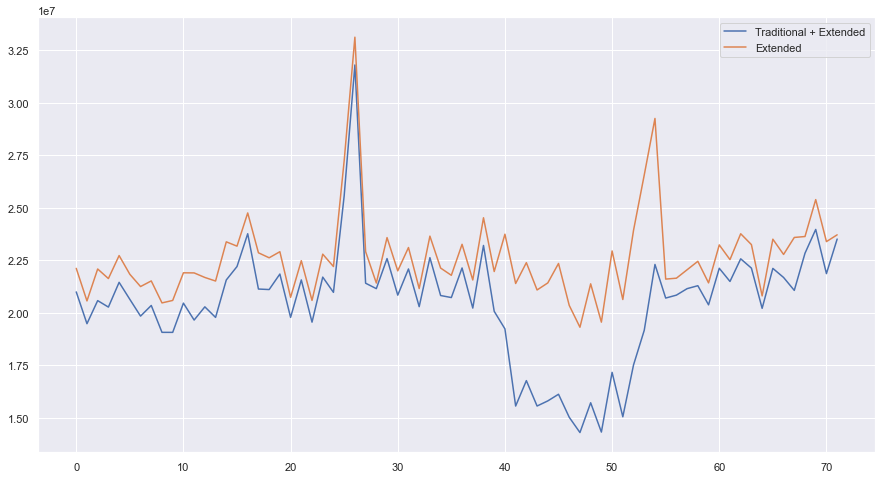

In [41]:
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week','sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot()

aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week','sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax=ax)

ax.legend(labels=['Traditional + Extended', 'Extended']);


### **H7** Lojas abertas durante o feriado de Natal deveriam vender mais.
**FALSA** Lojas não vendem mais durante o feriado de Natal, em comparação com os outros feriados.

<AxesSubplot:xlabel='year', ylabel='sales'>

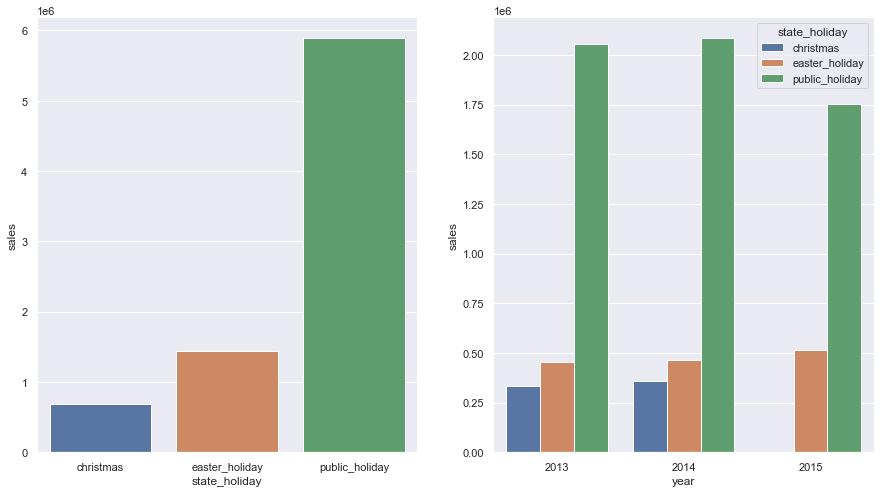

In [42]:
plt.subplot(1, 2, 1)
aux = df4[df4['state_holiday'] !='regular_day']
aux1 = aux[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x='state_holiday' ,y='sales' ,data= aux1)

plt.subplot(1, 2, 2)
aux2 = aux[['year','state_holiday','sales']].groupby(['year','state_holiday']).sum().reset_index()
sns.barplot(x='year' ,y='sales', hue='state_holiday', data=aux2 )

### **H8** Lojas deveriam vender mais ao longo dos anos.
**FALSA** Lojas estão vendendo menos ao longo dos anos

<AxesSubplot:>

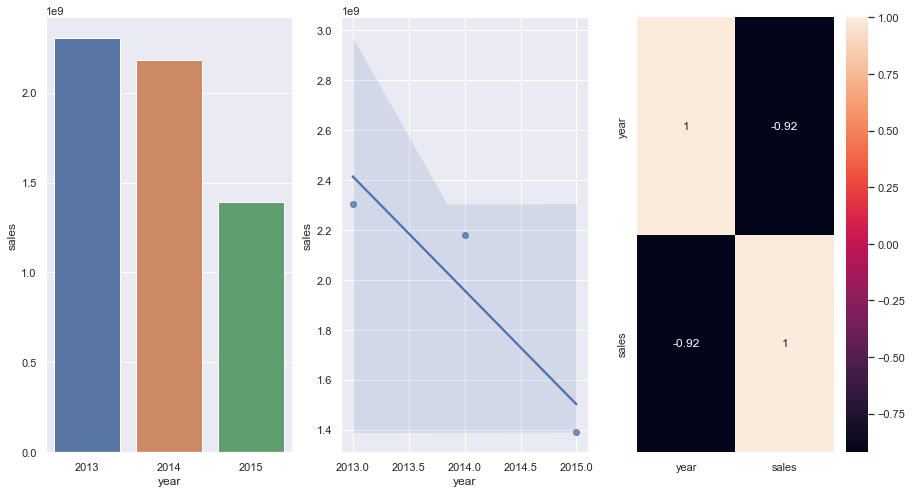

In [43]:
plt.subplot(1,3,1)
aux1 = df4[['year','sales']].groupby('year').sum().reset_index()
sns.barplot(x='year', y='sales', data=aux1);

plt.subplot(1,3,2)
sns.regplot(x='year', y='sales', data=aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)

### **H9** Lojas deveriam vender mais no segundo semestre do ano.

**VERDADEIRA** Removendo a ano de 2015, pode ver que as lojas vendem mais no segundo semestre.

<AxesSubplot:>

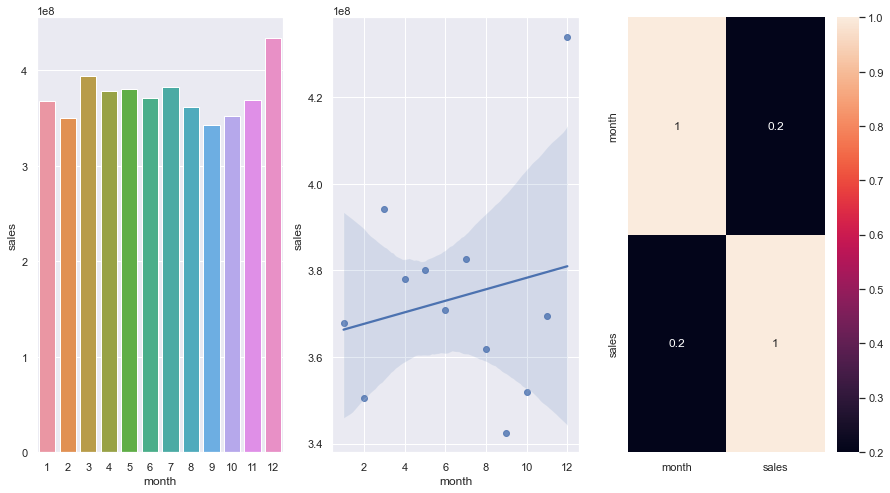

In [44]:
plt.subplot(1,3,1)
aux = df4[df4['year'] < 2015]
aux1 = aux[['month','sales']].groupby('month').sum().reset_index()
sns.barplot(x='month', y='sales', data=aux1);

plt.subplot(1,3,2)
sns.regplot(x='month', y='sales', data=aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)

### **H10** Lojas deveriam vender mais depois do dia 10 de cada mês.
**VERDADEIRA** Lojas vendem mais depois do dia 10 de cada mês

<AxesSubplot:xlabel='before_after', ylabel='sales'>

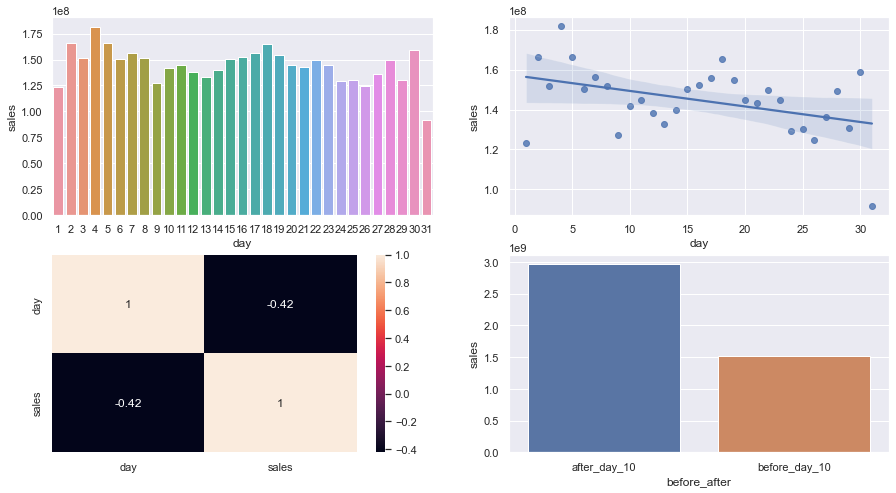

In [45]:
plt.subplot(2,2,1)
aux1 = aux[['day','sales']].groupby('day').sum().reset_index()
sns.barplot(x='day', y='sales', data=aux1);

plt.subplot(2,2,2)
sns.regplot(x='day', y='sales', data=aux1);

plt.subplot(2,2,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)

plt.subplot(2,2,4)
aux1['before_after'] = aux1['day'].apply(lambda x: 'before_day_10'if x <= 10 else 'after_day_10')
aux2 = aux1[['before_after','sales']].groupby('before_after').sum().reset_index()
sns.barplot(x='before_after', y='sales', data = aux2)



### **H11** Lojas deveriam vender menos aos finais de semana.
**VERDADEIRA**Lojas vendem menos nos finais de semana

<AxesSubplot:>

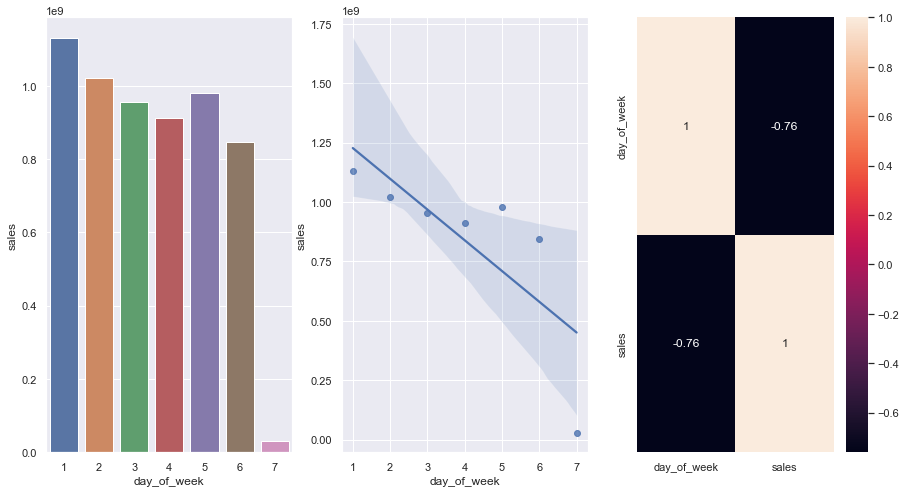

In [46]:
plt.subplot(1,3,1)
aux1 = df4[['day_of_week','sales']].groupby('day_of_week').sum().reset_index()
sns.barplot(x='day_of_week', y='sales', data=aux1);

plt.subplot(1,3,2)
sns.regplot(x='day_of_week', y='sales', data=aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)

### H12 Lojas deveriam vender menos durante os feriados escolares
**VERDADEIRA** Lojas vendem menos em todos os meses do ano, exceto julho e agosto

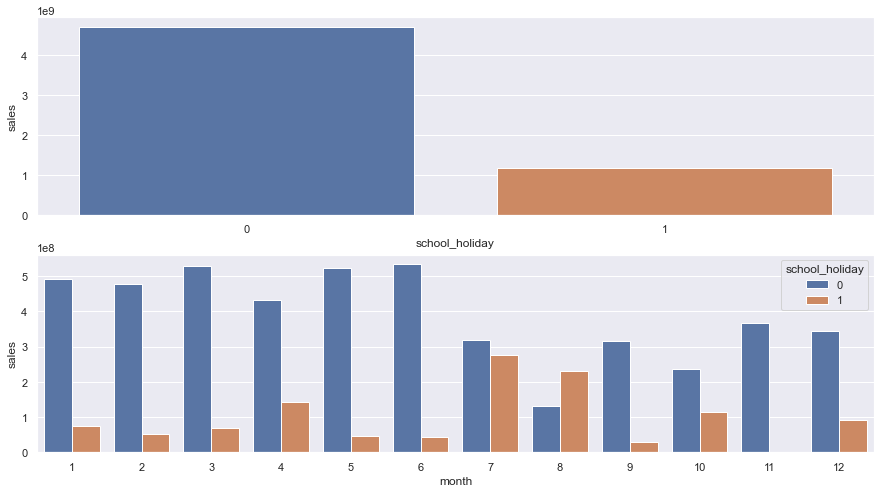

In [47]:
plt.subplot(2,1,1)
aux1 = df4[['school_holiday','sales']].groupby('school_holiday').sum().reset_index()
sns.barplot(x='school_holiday', y='sales', data=aux1);

plt.subplot(2,1,2)
aux1 = df4[['month','school_holiday','sales']].groupby(['month','school_holiday']).sum().reset_index()
sns.barplot(x='month', y='sales',hue= 'school_holiday', data=aux1);


## 4.1 Análise Multivariada

### 4.3.1 Numerical atributes

<AxesSubplot:>

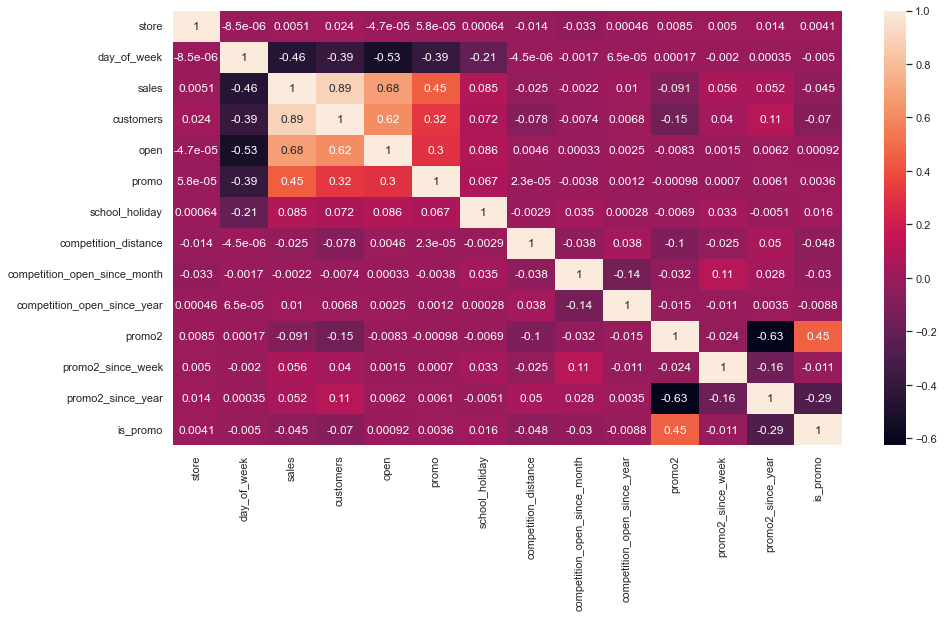

In [48]:
correlation = num_attributes.corr(method='pearson')
sns.heatmap(correlation, annot = True)

### 4.3.2 Categorical atributes

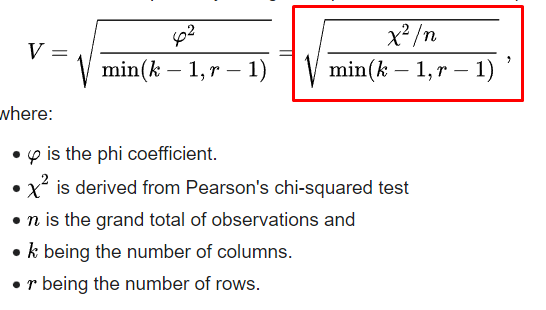

In [49]:
Image('img\cramerv.png')

<AxesSubplot:>

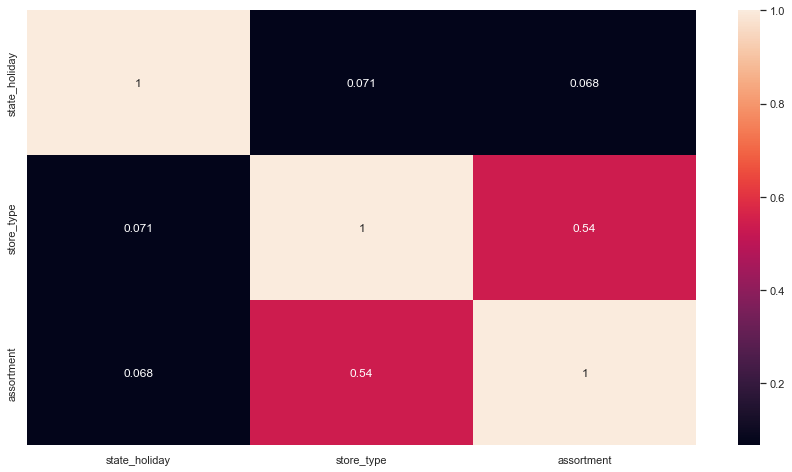

In [50]:
#getting only categorical data
a = df4.select_dtypes( include ='object')

#calculate cramer's v
a1 = cramer_v(a['state_holiday'], a['state_holiday'])
a2 = cramer_v(a['state_holiday'], a['store_type'])
a3 = cramer_v(a['state_holiday'], a['assortment'])

a4 = cramer_v(a['store_type'], a['state_holiday'])
a5 = cramer_v(a['store_type'], a['store_type'])
a6 = cramer_v(a['store_type'], a['assortment'])

a7 = cramer_v(a['assortment'], a['state_holiday'])
a8 = cramer_v(a['assortment'], a['store_type'])
a9 = cramer_v(a['assortment'], a['assortment'])

# Final dataset
d = pd.DataFrame({'state_holiday':[a1, a2, a3],
              'store_type':[a4, a5, a6],
              'assortment':[a7, a8, a9]  })

d = d.set_index(d.columns)
sns.heatmap(d, annot = True)

# 5.0. PASSO 5 - DATA PREPARATION

In [121]:
df5 = df4.copy()

## 5.1. Normalização

**Ao analisar as variáveis, vimos que nao temos nenhuma distribuição normal que possamos normalizar, então vamops seguir para o Rescaling**

## 5.2. Rescaling

In [122]:
rs = RobustScaler()
mms = MinMaxScaler()

# competition distance
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values )
pickle.dump(rs, open ('parameter/competition_distance_scaler', 'wb') )

# competition time month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values )
pickle.dump(rs, open ('parameter/competition_time_month_scaler', 'wb') )

# Promo time week 
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values )
pickle.dump(mms, open ('parameter/promo_time_week_scaler', 'wb') )

# year
df5['year'] = mms.fit_transform(df5[['year']].values )
pickle.dump(mms, open ('parameter/year_scaler', 'wb') )


## 5.3. Transformação

### 5.3.1 Encoding

In [123]:
# state_holiday - One Hot Encoding 
df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'] )

# store_type - Label Encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])
pickle.dump(le, open ('parameter/store_type_scaler', 'wb') )

# assortment - Ordinal Encoding
assort_dict = {'basic':1 , 'extra':2, 'extended':3}
df5['assortment'] = df5['assortment'].map(assort_dict)


### 5.3.2 Response variable transformation

In [54]:
df5['sales'] = np.log1p(df5['sales'])

### 5.3.3 Nature Transformation

In [55]:
# month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin( x * ( 2. * np.pi/12 ) ) )
df5['month_cos'] = df5['month'].apply(lambda x: np.cos( x * ( 2. * np.pi/12 ) ) )

# day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin( x *  ( 2. * np.pi/30 ) ) )
df5['day_cos'] = df5['day'].apply(lambda x: np.cos( x *  ( 2. * np.pi/30 ) ) )

# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin( x * ( 2. * np.pi/52 ) ) )
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos( x * ( 2. *  np.pi/52 ) ) )

# day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin( x * ( 2. *  np.pi/7 ) ) )
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos( x * ( 2. *  np.pi/7 ) ) )


# 6.0. PASSO 6 - FEATURE SELECTION -  BORUTA

In [56]:
df6 = df5.copy()

## 6.1 Split Dataframe into training and test dataset

In [57]:
cols_drop = ['week_of_year','day','month','day_of_week','promo_since','competition_since','year_week']
df6 = df6.drop(cols_drop, axis=1)

In [58]:
df6[['store','date']].groupby(['store']).max().reset_index()['date'][0] - datetime.timedelta(days= 6*7)

Timestamp('2015-06-19 00:00:00')

In [59]:
# training dataset
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

#test dateset
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

print('Training Min date {}'.format(X_train['date'].min() ) )
print('Training Max date {}'.format(X_train['date'].max() ) )

print('\nTest Min date {}'.format(X_test['date'].min() ) )
print('Test Max date {}'.format(X_test['date'].max() ) )

Training Min date 2013-01-01 00:00:00
Training Max date 2015-06-18 00:00:00

Test Min date 2015-06-19 00:00:00
Test Max date 2015-07-31 00:00:00


In [60]:
X_test.head()

,store,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,competition_time_month,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos,day_of_week_sin,day_of_week_cos
0,1,2015-07-31,8.568646,1,1,2,1,-0.170968,9,2008,0,31,2015,0,1.0,0.918919,0.287016,0,0,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
1,2,2015-07-31,8.710290,1,1,0,1,-0.283871,11,2007,1,13,2010,1,1.0,1.054054,0.922551,0,0,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
2,3,2015-07-31,9.025816,1,1,0,1,1.903226,12,2006,1,14,2011,1,1.0,1.202703,0.801822,0,0,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
3,4,2015-07-31,9.546527,1,1,2,3,-0.275806,9,2009,0,31,2015,0,1.0,0.743243,0.287016,0,0,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
4,5,2015-07-31,8.481151,1,1,0,1,4.448387,4,2015,0,31,2015,0,1.0,-0.162162,0.287016,0,0,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521


## 6.2 Boruta as feature selection

In [61]:
# # training and test dataset for boruta
#X_train_n = X_train.drop(['date','sales'], axis=1 ).values
# y_train_n = y_train.values.ravel()

# # define Random Forest
# rf = RandomForestRegressor( n_jobs=-1 )

# # define Boruta
# boruta = BorutaPy( rf, n_estimators='auto', verbose=2, random_state=42 ).fit( X_train_n, y_train_n )

### 6.2.1 Best features from Boruta

In [62]:
# cols_selected = boruta.support_.tolist()

# # best features
# X_train_fs = x_train.drop( ['date','sales'], axis = 1 )
# cols_selected_boruta = X_train_fs.iloc[: , cols_selected].columns.to_list()

# # not selected boruta
# cols_not_selected_boruta = list( np.setdiff1d( X_train_fs.columns, cols_selected_boruta ) )

## 6.3 Manual feature selection

In [63]:
cols_selected_boruta = [
        'store',
        'promo',
        'store_type',
        'assortment',
        'competition_distance',
        'competition_open_since_month',
        'competition_open_since_year',
        'promo2',
        'promo2_since_week',
        'promo2_since_year',
        'competition_time_month',
        'promo_time_week',
        'month_cos',
        'month_sin',
        'day_sin',
        'day_cos',
        'week_of_year_sin',
        'week_of_year_cos',
        'day_of_week_sin',
        'day_of_week_cos']

# columns to add
feat_to_add = ['date','sales']

# final features

cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend( feat_to_add )

# 7.0. PASSO 7 - MACHINE LEARNING MODELING

In [64]:
x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]

# Time Series data prepatation

x_training = X_train[cols_selected_boruta_full]

## 7.1 Average Model

In [65]:
aux1= x_test.copy()
aux1['sales'] = y_test.copy()

#prediction
aux2 = aux1[['store', 'sales']].groupby('store').mean().reset_index().rename(columns={'sales': 'predictions' } )
aux1 = pd.merge(aux1, aux2, how='left', on ='store')
yhat_baseline = aux1['predictions']


#performance
baseline_result = ml_error('Average Model',np.expm1(y_test), np.expm1(yhat_baseline))
baseline_result




,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.455051,1835.135542


## 7.2 Linear Regression Model

In [66]:
#Model
lr = LinearRegression().fit( x_train, y_train )

# Prediction
yhat_lr = lr.predict(x_test)

# Performance
lr_result = ml_error('Liner Regression', np.expm1(y_test), np.expm1(yhat_lr))
lr_result

,Model Name,MAE,MAPE,RMSE
0,Liner Regression,1867.089774,0.292694,2671.049215


### 7.2.1 Linear Regression Model - CV

In [67]:
lr_result_cv = cross_validation( x_training, 5, 'Liner Regression', lr, verbose=False )
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Liner Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37


## 7.3 Linear Regression Regularized Model - Lasso

In [68]:
#Model
lrr = Lasso( alpha=0.01 ).fit( x_train, y_train )

# Prediction
yhat_lrr = lrr.predict(x_test)

# Performance
lrr_result = ml_error('Liner Regression - Lasso', np.expm1(y_test), np.expm1(yhat_lrr))
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Liner Regression - Lasso,1891.70488,0.289106,2744.451735


### 7.3.1 Linear Regression Regularized Model - Lasso - CV

In [69]:
lrr_result_cv = cross_validation( x_training, 5, 'Lasso', lrr, verbose=False )
lrr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26


## 7.4 Random Forest Regressor

In [70]:
#Model
rf = RandomForestRegressor(n_estimators=100,n_jobs=-1,random_state=42 ).fit( x_train, y_train )

# Prediction
yhat_rf = rf.predict(x_test)

# Performance
rf_result = ml_error('Random Forest Regressor', np.expm1(y_test), np.expm1(yhat_rf))
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,678.865295,0.099845,1009.761326


### 7.4.1 Random Forest Regressor - CV

In [71]:
rf_result_cv = cross_validation( x_training, 5, 'Random Forest Regressor', rf, verbose=True )
rf_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,838.51 +/- 218.77,0.12 +/- 0.02,1257.82 +/- 319.1


## 7.5 XGBoost Regressor

In [72]:
#Model

model_xgb = xgb.XGBRegressor(objective='reg:squarederror',
                             n_estimators=100,
                             eta=0.01,
                             max_depth=10,
                             subsample=0.7,
                             colsample_bytree=0.9).fit( x_train, y_train )

# Prediction
yhat_xgb = model_xgb.predict(x_test)

# Pexgbormance
xgb_result = ml_error('XGBoost', np.expm1(y_test), np.expm1(yhat_xgb))
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost,6683.618003,0.949469,7330.888804


### 7.5.1 XGBoost Regressor - CV

In [73]:
xgb_result_cv = cross_validation( x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True )
xgb_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,7049.19 +/- 588.53,0.95 +/- 0.0,7715.24 +/- 689.39


## 7.6 Compare Model's Performance

### 7.6.1 Single Performance

In [74]:
modelling_result = pd.concat( [baseline_result, lr_result, lrr_result, rf_result, xgb_result] )
modelling_result.sort_values('RMSE')

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,678.865295,0.099845,1009.761326
0,Average Model,1354.800353,0.455051,1835.135542
0,Liner Regression,1867.089774,0.292694,2671.049215
0,Liner Regression - Lasso,1891.704880,0.289106,2744.451735
0,XGBoost,6683.618003,0.949469,7330.888804


### 7.6.2 Real Performance - CV

In [75]:
modelling_result_cv = pd.concat( [lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv] )
modelling_result_cv.sort_values('RMSE CV')

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,838.51 +/- 218.77,0.12 +/- 0.02,1257.82 +/- 319.1
0,Liner Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37
0,Lasso,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26
0,XGBoost Regressor,7049.19 +/- 588.53,0.95 +/- 0.0,7715.24 +/- 689.39


# 8.0. PASSO 8 - FINE TUNNING

## 8.1. Random Search

In [76]:
import random
import warnings
warnings.filterwarnings( 'ignore' )

In [77]:
param = { 
        'n_estimators':[1500, 1700, 2500, 3000, 3500],
        'eta':[0.01,0.03],
        'max_depth':[3, 5, 9],
        'subsample':[0.1, 0.5, 0.7],
        'colsample_bytree':[0.3, 0.7, 0.9],
        'min_child_weight':[3, 8, 15]
        }
MAX_EVAL = 5

In [89]:
# final_result = pd.DataFrame()

# for i in range( MAX_EVAL):
#     #escolhe valores aleatoriamente 
#     hp = { k: random.sample(v, 1)[0] for k, v in param.items() }
#     print(hp)
    
#     #model
#     model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
#                                   n_estimators=hp['n_estimators'],
#                                   eta=hp['eta'],
#                                   max_depth=hp['max_depth'],
#                                   subsample=hp['subsample'],
#                                   colsample_bytree=hp['colsample_bytree'],
#                                   min_child_weight=hp['min_child_weight'] )
#  # performance
#     print('\niniciando cross-validation para os parâmentros selecionados')
    
#     result = cross_validation( x_training, 5, 'XGBoost Regressor', model_xgb,verbose=True )
#     final_result = pd.concat( [final_result, result] )    
   
#     print('\ncross-validation finalizado e anexado no final_result')

In [79]:
final_result

,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,1222.5 +/- 129.22,0.17 +/- 0.01,1752.25 +/- 162.75
0,XGBoost Regressor,1389.58 +/- 130.53,0.19 +/- 0.01,1998.68 +/- 164.41
0,XGBoost Regressor,1083.14 +/- 141.82,0.15 +/- 0.01,1561.67 +/- 182.08
0,XGBoost Regressor,855.77 +/- 146.33,0.12 +/- 0.01,1235.48 +/- 210.53
0,XGBoost Regressor,1466.31 +/- 152.7,0.2 +/- 0.01,2109.92 +/- 193.32


## 8.2. Final Model

In [81]:
# param_tuned = {
# 'n_estimators': 3000,
# 'eta': 0.03,
# 'max_depth': 5,
# 'subsample': 0.7,
# 'colsample_bytree': 0.7,
# 'min_child_weight': 3
# }

param_tuned = {
'n_estimators': 2500,
'eta': 0.01,
'max_depth': 9,
'subsample': 0.7,
'colsample_bytree': 0.7,
'min_child_weight': 15
}

In [83]:
# model
model_xgb_tuned = xgb.XGBRegressor( objective='reg:squarederror',
                                    n_estimators=param_tuned['n_estimators'],
                                    eta=param_tuned['eta'],
                                    max_depth=param_tuned['max_depth'],
                                    subsample=param_tuned['subsample'],
                                    colsample_bytree=param_tuned['colsample_bytree'],
                                    min_child_weight=param_tuned['min_child_weight'] ).fit( x_train, y_train )

# prediction
yhat_xgb_tuned = model_xgb_tuned.predict( x_test )

# performance
xgb_result_tuned = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1(yhat_xgb_tuned ) )
xgb_result_tuned

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,696.49226,0.102598,1019.432856


In [86]:
mpe = mean_percentage_error( np.expm1(y_test), np.expm1(yhat_xgb_tuned))
mpe

-0.006010687918496443

TypeError: open() missing required argument 'file' (pos 1)

# 9.0. PASSO 9 - TRADUÇÃO E INTERPRETAÇÃO DOS DADOS

In [90]:
df9 = X_test[ cols_selected_boruta_full ]

#rescale
df9['sales'] = np.expm1( df9['sales'] )
df9['predictions'] = np.expm1(yhat_xgb_tuned)

## 9.1 -  Business Performance

In [102]:
# sum of predictions
df91 = df9[['store', 'predictions']].groupby( 'store' ).sum().reset_index()

# MAE and MAPE
df9_aux1 = df9[['store', 'sales', 'predictions']].groupby( 'store' ).apply(lambda x: mean_absolute_error( x['sales'], x['predictions'] ) ).reset_index().rename( columns={0:'MAE'})
df9_aux2 = df9[['store', 'sales', 'predictions']].groupby( 'store' ).apply(lambda x: mean_absolute_percentage_error( x['sales'], x['predictions'] ) ).reset_index().rename( columns={0:'MAPE'})

# Merge
df9_aux3 = pd.merge( df9_aux1, df9_aux2, how='inner', on='store' )
df92 = pd.merge( df91, df9_aux3, how='inner', on='store' )

df92['MAE'] = df92['predictions'] * df92['MAPE']
# Scenarios
df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']
# order columns
df92 = df92[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE','MAPE']]

In [107]:
df92.sample(5)

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
865,866,252185.84375,232864.811657,271506.875843,19321.032093,0.076614
523,524,314692.25000,291483.367393,337901.132607,23208.882607,0.073751
114,115,289710.65625,263923.159555,315498.152945,25787.496695,0.089011
817,818,223348.90625,206096.866052,240600.946448,17252.040198,0.077243
53,54,286523.15625,265385.242653,307661.069847,21137.913597,0.073774


<AxesSubplot:xlabel='store', ylabel='MAPE'>

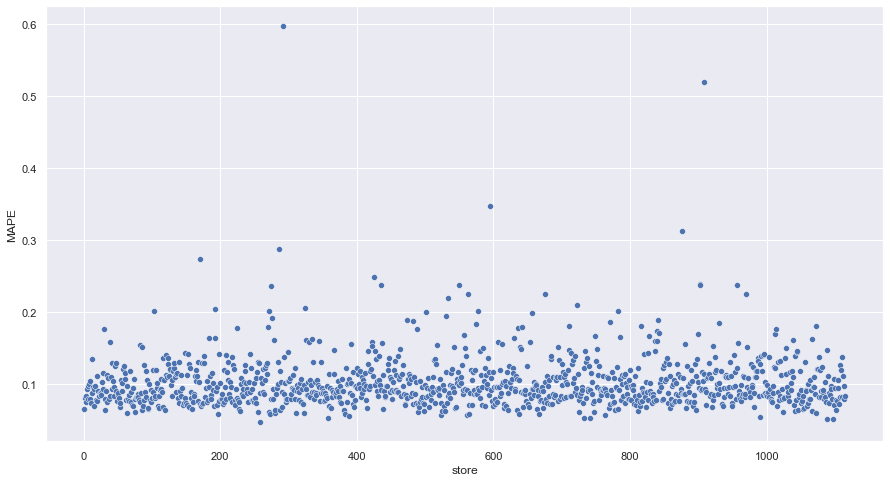

In [95]:
 sns.scatterplot( x='store', y='MAPE', data=df92 )


## 9.2 -  Total Performance

In [106]:
df93 = df92[['predictions', 'worst_scenario', 'best_scenario']].apply( lambda x: np.sum( x ), axis=0 ).reset_index().rename( columns={'index': 'Scenario', 0:'Values'} )
df93['Values'] = df93['Values'].map( 'R${:,.2f}'.format )
df93

,Scenario,Values
0,predictions,"R$283,796,832.00"
1,worst_scenario,"R$255,177,168.14"
2,best_scenario,"R$312,416,497.10"


## 9.3 - Machine Learning Performance

In [108]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

<AxesSubplot:xlabel='predictions', ylabel='error'>

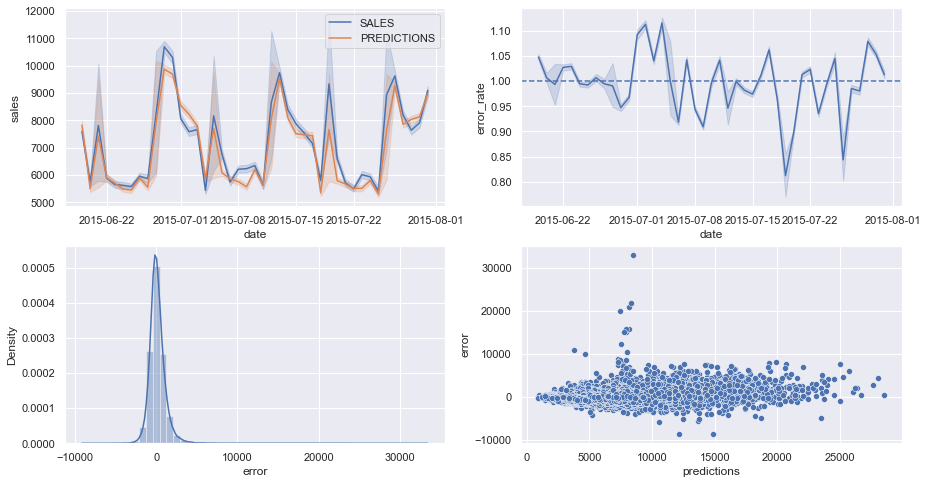

In [109]:
plt.subplot( 2, 2, 1 )
sns.lineplot( x='date', y='sales', data=df9, label='SALES' )
sns.lineplot( x='date', y='predictions', data=df9, label='PREDICTIONS' )

plt.subplot( 2, 2, 2 )
sns.lineplot( x='date', y='error_rate', data=df9 )
plt.axhline( 1, linestyle='--')

plt.subplot( 2, 2, 3 )
sns.distplot( df9['error'] )

plt.subplot( 2, 2, 4 )
sns.scatterplot( df9['predictions'], df9['error'] )

# 10.0. PASSO 10 - DEPLOY MODEL TO PRODUCTION

In [140]:
pickle.dump(model_xgb_tuned, open(r'C:\Users\vande\Repos\ds-em-producao\model\model_rossmann.pkl', 'wb') ) 

## 10.1.  Rossmann Class

In [206]:
import math
import pickle
import datetime
import inflection
import numpy as np
import pandas as pd

class Rossmann( object ):
    def __init__( self ):
        self.home_path = '/Users/vande/Repos/ds-em-producao/'
        self.competition_time_month_scaler = pickle.load(open (self.home_path + 'parameter/competition_time_month_scaler', 'rb') )
        self.competition_distance_scaler =   pickle.load(open (self.home_path + 'parameter/competition_distance_scaler', 'rb') )
        self.promo_time_week_scaler =        pickle.load(open (self.home_path + 'parameter/promo_time_week_scaler', 'rb') )
        self.store_type_scaler =             pickle.load(open (self.home_path + 'parameter/store_type_scaler', 'rb') )
        self.year_scaler =                   pickle.load(open (self.home_path + 'parameter/year_scaler', 'rb') )    
      
    def data_cleaning (self, df1):
        
        ## 1.1 Rename Columns
        cols_old =[ 'Store', 'DayOfWeek', 'Date', 'Open', 'Promo',
                    'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
                    'CompetitionDistance', 'CompetitionOpenSinceMonth',
                    'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
                    'Promo2SinceYear', 'PromoInterval']

        snakecase = lambda x : inflection.underscore( x )
        cols_new = list( map( snakecase,cols_old ) )

        #rename
        df1.columns = cols_new

        ## 1.3 Data Types
        df1['date']=pd.to_datetime(df1['date'])

        # competition_distance    
        df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

        # competition_open_since_month 
        df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month']) else x['competition_open_since_month'],axis=1)

        # competition_open_since_year  
        df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year']) else x['competition_open_since_year'],axis=1)

        # promo2_since_week
        df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week']) else x['promo2_since_week'],axis=1)

        # promo2_since_year            
        df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year']) else x['promo2_since_year'],axis=1)

        # promo_interval 
        month_map = {  1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec' }

        df1['promo_interval'].fillna( 0, inplace=True )

        df1['month_map'] = df1['date'].dt.month.map( month_map)

        df1['is_promo'] = df1[['promo_interval','month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis =1)


        ## 1.6 Change Types
        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype('int64')
        df1['competition_open_since_year'] = df1['competition_open_since_year'].astype("int64")
        
        ## promo2
        df1['promo2_since_week'] = df1['promo2_since_week'].astype("int64")
        df1['promo2_since_year'] = df1['promo2_since_year'].astype("int64")
        
        return df1
    
    

    def feature_engineering(self, df2):

        # year
        df2['year'] = df2['date'].dt.year
        # month
        df2['month'] = df2['date'].dt.month

        # day
        df2['day'] = df2['date'].dt.day

        # week of year
        df2['week_of_year'] = df2['date'].dt.weekofyear

        # year week
        df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

        # competition since
        df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'] , month= x['competition_open_since_month'], day= 1 ), axis=1 )

        df2['competition_time_month'] = ((df2['date'] - df2['competition_since']) / 30).apply(lambda x: x.days).astype(int)

        # promo since
        df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
        df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ))

        df2['promo_time_week'] =  ((df2['date'] - df2['promo_since']) / 7).apply(lambda x: x.days).astype(int)

        # assorment
        df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x =='b' else 'extended')

        # state holiday
        df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x== 'b' else 'christmas' if x =='c' else 'regular_day')

        # 3.0. PASSO 3 - FILTRAGEM DE VARIÁVEIS

        ## 3.1. Filtragem das Linhas
        df2 = df2[df2['open']!= 0]

        ## 3.2. Seleção da colunas
        cols_drop = ['open','promo_interval','month_map']
        df2 = df2.drop(cols_drop, axis=1)
        
        return df2 

    def data_preparation(self, df5):

        ## 5.2. Rescaling
        # competition distance
        df5['competition_distance'] = self.competition_distance_scaler.transform(df5[['competition_distance']].values )

        # competition time month
        df5['competition_time_month'] = self.competition_time_month_scaler.transform(df5[['competition_time_month']].values )

        # Promo time week 
        df5['promo_time_week'] = self.promo_time_week_scaler.transform(df5[['promo_time_week']].values )
      
        # year
        df5['year'] = self.year_scaler.transform(df5[['year']].values )
        
        ## 5.3. Transformação
        
        ### 5.3.1 Encoding
        
        # state_holiday - One Hot Encoding 
        df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'] )

        # store_type - Label Encoding
        df5['store_type'] = self.store_type_scaler.transform(df5['store_type'])


        # assortment - Ordinal Encoding
        assort_dict = {'basic':1 , 'extra':2, 'extended':3}
        df5['assortment'] = df5['assortment'].map(assort_dict)

        ### 5.3.3 Nature Transformation

        # month
        df5['month_sin'] = df5['month'].apply(lambda x: np.sin( x * ( 2. * np.pi/12 ) ) )
        df5['month_cos'] = df5['month'].apply(lambda x: np.cos( x * ( 2. * np.pi/12 ) ) )

        # day
        df5['day_sin'] = df5['day'].apply(lambda x: np.sin( x *  ( 2. * np.pi/30 ) ) )
        df5['day_cos'] = df5['day'].apply(lambda x: np.cos( x *  ( 2. * np.pi/30 ) ) )

        # week of year
        df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin( x * ( 2. * np.pi/52 ) ) )
        df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos( x * ( 2. *  np.pi/52 ) ) )

        # day of week
        df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin( x * ( 2. *  np.pi/7 ) ) )
        df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos( x * ( 2. *  np.pi/7 ) ) )

        cols_selected = ['store', 'promo', 'store_type', 'assortment', 'competition_distance', 'competition_open_since_month', 'competition_open_since_year', 'promo2', 'promo2_since_week',   'promo2_since_year', 'competition_time_month', 'promo_time_week', 'month_cos', 'month_sin', 'day_sin', 'day_cos', 'week_of_year_sin', 'week_of_year_cos', 'day_of_week_sin', 'day_of_week_cos']
        
        return df5[ cols_selected ]
    
    def get_prediction( self, model, original_data, test_data ):
        #prediction
        pred = model.predict( test_data )
        
        #join pred into de original data
        original_data['prediction'] = np.expm1( pred )
        
        return original_data.to_json( orient='records',date_format='iso' )

## 10.2.  API Handler

## 10.3. API Tester

In [201]:
import requests

In [146]:
# loading test dataset
df10 = pd.read_csv(r'C:\Users\vande\Repos\ds-em-producao\data\test.csv')

In [219]:
# merge df10 + df_store_raw (test dataset + stores feature)
df_test = pd.merge(df10, df_store_raw, how='left', on='Store')

# choose store for prediction
df_test = df_test[df_test['Store'].isin([24,12,22,15,1,2,63])]

# remove closed days 
df_test = df_test[df_test['Open'] != 0]
df_test = df_test[~df_test['Open'].isnull() ]
df_test = df_test.drop('Id', axis=1)

In [220]:
#convert dataframe to jason
data = json.dumps( df_test.to_dict( orient='records' ) )

In [221]:
# API Call 
url = 'http://192.168.100.12:5000/rossmann/predict'
header = { 'Content-type': 'application/json' }
data = data

r = requests.post( url, data=data, headers=header)
print(f'Status code {r.status_code}')

Status code 200


In [222]:
d1 = pd.DataFrame(r.json(), columns=r.json()[0].keys() )

In [223]:
d2 = d1[['store','prediction']].groupby('store').sum().reset_index()

for i in range( len( d2 ) ):
    print('Store Number {} will sell R${:,.2f} in the next 6 weeks'.format(
                                                                d2.loc[i,'store'],
                                                                d2.loc[i,'prediction'] ) )        

Store Number 1 will sell R$179,157.97 in the next 6 weeks
Store Number 12 will sell R$301,284.71 in the next 6 weeks
Store Number 15 will sell R$275,269.47 in the next 6 weeks
Store Number 22 will sell R$180,397.56 in the next 6 weeks
Store Number 24 will sell R$387,338.61 in the next 6 weeks
Store Number 63 will sell R$281,378.11 in the next 6 weeks
